# Imports

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# Initialization

In [26]:
data = pd.read_csv('DATASET_FINAL.csv')
data.drop('Unnamed: 0', axis=1)

,Date,Price,Open,High,Low,Vol.,Change %
0,"Sep 18, 2020",43.15,43.22,43.80,42.53,204.66K,-0.35%
1,"Sep 17, 2020",43.30,42.32,43.50,41.50,237.40K,2.56%
2,"Sep 16, 2020",42.22,40.72,42.44,40.59,237.25K,4.17%
3,"Sep 15, 2020",40.53,39.70,40.82,39.39,214.80K,2.32%
4,"Sep 14, 2020",39.61,39.78,40.09,39.30,200.09K,-0.55%
...,...,...,...,...,...,...,...
8222,"Jul 01, 1988",14.60,14.60,14.60,14.60,0.05K,-1.68%
8223,"Jun 30, 1988",14.85,14.80,14.90,14.80,0.42K,-4.01%
8224,"Jun 29, 1988",15.47,15.47,15.47,15.47,-,1.31%
8225,"Jun 28, 1988",15.27,15.34,15.36,15.27,0.16K,1.13%


# Preprocessing

In [27]:
data['Date'] = data['Date'].apply(lambda x: pd.to_datetime(x))
data.drop([8224])
data=data.iloc[::-1]
data = data.reset_index().drop('index', axis=1)
data = data.fillna(0)
data = data[['Date', 'Price']]

In [28]:
data['Price_ND']=data['Price'].shift(-1)
for i in range(1,32):
    data['Price_LD_{}'.format(i)]=data['Price'].shift(i)
autoreg_columns = ['Price_LD_{}'.format(i) for i in range(1, 16)]

In [29]:
data['moving_mean_all_autoreg'] = data[autoreg_columns].mean(axis=1)
data['moving_std_all_autoreg'] = data[autoreg_columns].std(axis=1)
data['moving_min_all_autoreg'] = data[autoreg_columns].min(axis=1)
data['moving_max_all_autoreg'] = data[autoreg_columns].max(axis=1)

In [30]:
data = data.dropna(subset=['Price_ND'], axis=0)

In [31]:
data.head()

,Date,Price,Price_ND,Price_LD_1,Price_LD_2,Price_LD_3,Price_LD_4,Price_LD_5,Price_LD_6,Price_LD_7,...,Price_LD_26,Price_LD_27,Price_LD_28,Price_LD_29,Price_LD_30,Price_LD_31,moving_mean_all_autoreg,moving_std_all_autoreg,moving_min_all_autoreg,moving_max_all_autoreg
0,1988-06-27,15.10,15.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1988-06-28,15.27,15.47,15.10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,15.1000,NaN,15.10,15.10
2,1988-06-29,15.47,14.85,15.27,15.10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,15.1850,0.120208,15.10,15.27
3,1988-06-30,14.85,14.60,15.47,15.27,15.10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,15.2800,0.185203,15.10,15.47
4,1988-07-01,14.60,14.35,14.85,15.47,15.27,15.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,15.1725,0.262853,14.85,15.47


# Predict with the help of catboost

In [32]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Date','Price_ND'], axis=1), data['Price_ND'], test_size=0.3, shuffle=False)

In [41]:
cat = CatBoostRegressor(depth = 7)

In [42]:
cat.fit(X_train, y_train, eval_set = (X_test, y_test), silent = True)

In [47]:
preds = cat.predict(X_test)
print(smape(preds,X_test.Price))

2.402536089748994


# Schedule of changes

No handles with labels found to put in legend.


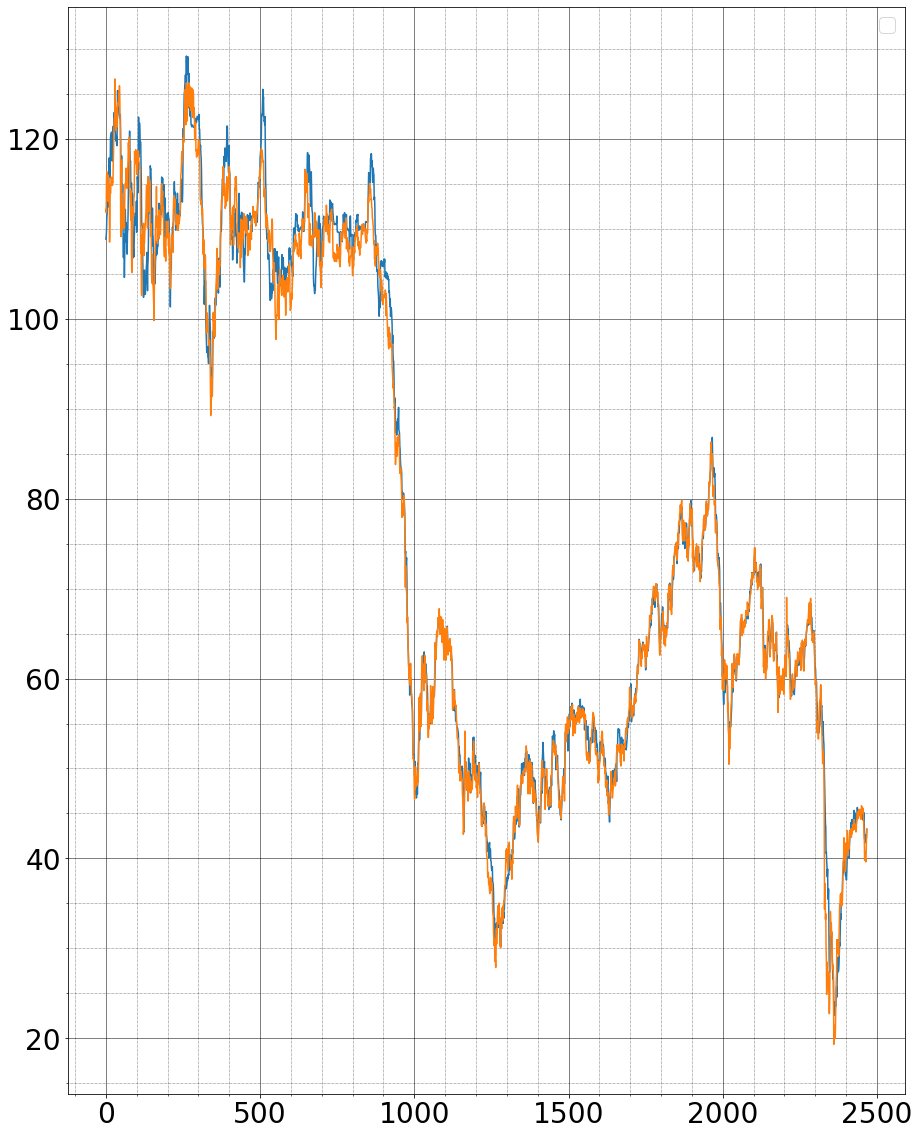

In [45]:
fig = plt.figure(figsize=(15, 20))
plt.legend(prop={'size': 20})
plt.minorticks_on()
plt.xticks(fontsize=14)
plt.grid(which='major', color='k',  linewidth = 0.5)
plt.grid(which='minor', color='k',  linestyle = ':', linewidth=0.5)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.plot(list(range(len(preds))), preds, label='preds')
plt.plot(list(range(len(preds))), X_test['Price'], label='real')

plt.savefig('graph1.jpeg', dpi=300)